<a href="https://colab.research.google.com/github/rodespdi/PDA2526/blob/main/Mascara_color.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title 1. Instalar e Importar Librerías
# Necesitamos 'ipympl' para que Matplotlib sea interactivo en Colab
!pip install ipympl

import cv2
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from google.colab import output
from google.colab.patches import cv2_imshow # cv2.imshow no funciona en Colab

# Habilitar el backend interactivo de matplotlib
from google.colab import output
output.enable_custom_widget_manager()
%matplotlib widget

In [ ]:
#@title 2. Descargar una imagen de ejemplo
# Usamos una imagen colorida para que las pruebas sean fáciles
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/6/6d/Good_Food_Display_-_NCI_Visuals_Online.jpg/1280px-Good_Food_Display_-_NCI_Visuals_Online.jpg -O imagen_ejemplo.jpg

--2025-11-03 17:34:36--  https://upload.wikimedia.org/wikipedia/commons/thumb/6/6d/Good_Food_Display_-_NCI_Visuals_Online.jpg/1280px-Good_Food_Display_-_NCI_Visuals_Online.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 377424 (369K) [image/jpeg]
Saving to: ‘imagen_ejemplo.jpg’

imagen_ejemplo.jpg  100%[===================>] 368.58K  --.-KB/s    in 0.01s   

2025-11-03 17:34:36 (32.3 MB/s) - ‘imagen_ejemplo.jpg’ saved [377424/377424]



Panel de Control de Filtro de Color


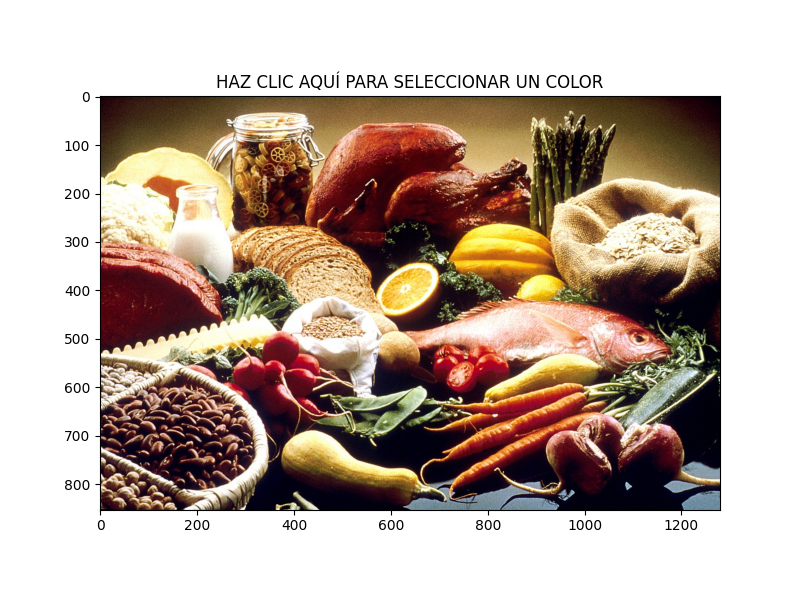

In [ ]:
#@title 3. Código Principal: Filtro de Color Interactivo

# --- Variables Globales y Carga de Imagen ---
ARCHIVO_IMAGEN = 'imagen_ejemplo.jpg'

# Cargar la imagen con OpenCV
bgr_image = cv2.imread(ARCHIVO_IMAGEN)

# Convertir a los espacios de color que usaremos
rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
hsv_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2HSV)

# Variables para guardar el estado
color_seleccionado_hsv = None

# --- Creación de Widgets ---

# 1. Sliders para los umbrales
# El Tono (Hue) es un círculo (0-179 en OpenCV), por eso su umbral es clave.
slider_umbral_h = widgets.IntSlider(
    value=10, min=1, max=90, step=1,
    description='Umbral Tono (H):',
    style={'description_width': 'initial'}
)
# Saturación y Valor (Brillo) los usamos como "mínimos" para filtrar blancos/negros
slider_min_s = widgets.IntSlider(
    value=50, min=0, max=255, step=1,
    description='Saturación (S) Mín:',
    style={'description_width': 'initial'}
)
slider_min_v = widgets.IntSlider(
    value=50, min=0, max=255, step=1,
    description='Valor (V) Mín:',
    style={'description_width': 'initial'}
)

# 2. Widgets de Salida para las imágenes
# Usamos 'Output' para poder limpiar y redibujar las imágenes dinámicamente
output_mascara = widgets.Output()
output_resultado = widgets.Output()

# --- Lógica de Procesamiento ---

def actualizar_mascara(change=None):
    """
    Esta función se llama cuando un slider cambia O cuando se hace clic.
    Redibuja la máscara y el resultado.
    """
    global color_seleccionado_hsv
    if color_seleccionado_hsv is None:
        # Aún no se ha seleccionado un color
        return

    # Obtener valores actuales de los sliders
    target_h = color_seleccionado_hsv[0]
    umbral_h = slider_umbral_h.value
    min_s = slider_min_s.value
    min_v = slider_min_v.value

    # --- Lógica de Umbral de Tono (Hue) ---
    # El Tono es circular. 'Rojo' está en 0 y 179.
    # Si el umbral cruza el '0', necesitamos dos máscaras.

    limite_inf_h = int(target_h) - umbral_h
    limite_sup_h = int(target_h) + umbral_h

    # Definir límites de Saturación y Valor
    limite_inf_sv = np.array([min_s, min_v])
    limite_sup_sv = np.array([255, 255])

    if limite_inf_h < 0:
        # El rango cruza el 0 (ej: Tono 5, Umbral 10 -> Rango de -5 a 15)
        # Rango 1: (179 + limite_inf_h) a 179
        rango1_inf = np.array([179 + limite_inf_h, min_s, min_v])
        rango1_sup = np.array([179, 255, 255])
        mascara1 = cv2.inRange(hsv_image, rango1_inf, rango1_sup)

        # Rango 2: 0 a limite_sup_h
        rango2_inf = np.array([0, min_s, min_v])
        rango2_sup = np.array([limite_sup_h, 255, 255])
        mascara2 = cv2.inRange(hsv_image, rango2_inf, rango2_sup)

        # Combinar máscaras
        mascara = cv2.bitwise_or(mascara1, mascara2)

    elif limite_sup_h > 179:
        # El rango cruza el 179 (ej: Tono 175, Umbral 10 -> Rango de 165 a 185)
        # Rango 1: limite_inf_h a 179
        rango1_inf = np.array([limite_inf_h, min_s, min_v])
        rango1_sup = np.array([179, 255, 255])
        mascara1 = cv2.inRange(hsv_image, rango1_inf, rango1_sup)

        # Rango 2: 0 a (limite_sup_h - 179)
        rango2_inf = np.array([0, min_s, min_v])
        rango2_sup = np.array([limite_sup_h - 179, 255, 255])
        mascara2 = cv2.inRange(hsv_image, rango2_inf, rango2_sup)

        # Combinar máscaras
        mascara = cv2.bitwise_or(mascara1, mascara2)

    else:
        # Rango normal (ej: Tono 100, Umbral 10 -> Rango 90 a 110)
        limite_inf = np.array([limite_inf_h, min_s, min_v])
        limite_sup = np.array([limite_sup_h, 255, 255])
        mascara = cv2.inRange(hsv_image, limite_inf, limite_sup)

    # Aplicar la máscara a la imagen RGB
    resultado = cv2.bitwise_and(rgb_image, rgb_image, mask=mascara)

    # --- Mostrar Resultados ---
    # Limpiar salidas anteriores
    output_mascara.clear_output(wait=True)
    output_resultado.clear_output(wait=True)

    # Mostrar la nueva máscara
    with output_mascara:
        print(f"Mostrando máscara...")
        # Convertir máscara de 1 canal a 3 para mostrarla
        cv2_imshow(cv2.cvtColor(mascara, cv2.COLOR_GRAY2BGR))

    # Mostrar el nuevo resultado
    with output_resultado:
        print(f"Mostrando resultado...")
        # La imagen 'resultado' ya es RGB, pero cv2_imshow espera BGR
        cv2_imshow(cv2.cvtColor(resultado, cv2.COLOR_RGB2BGR))


def on_pixel_click(event):
    """
    Esta función se llama CADA VEZ que se hace clic en la imagen.
    """
    global color_seleccionado_hsv

    # event.xdata e event.ydata son las coordenadas del píxel
    if event.xdata is None or event.ydata is None:
        return

    # Obtener coordenadas enteras
    x, y = int(event.xdata), int(event.ydata)

    # Capturar el color de la imagen HSV
    color_seleccionado_hsv = hsv_image[y, x]
    h, s, v = color_seleccionado_hsv

    # Capturar el color RGB para mostrarlo
    r, g, b = rgb_image[y, x]

    # Actualizar el título de la figura con el color seleccionado
    fig_imagen.suptitle(
        f'Color seleccionado en (x:{x}, y:{y}) -> '
        f'HSV: ({h}, {s}, {v}) | RGB: ({r}, {g}, {b})',
        fontsize=10
    )

    # Una vez que tenemos el nuevo color, actualizamos la máscara
    actualizar_mascara()

# --- Conectar Widgets y Eventos ---

# 1. Conectar los sliders a la función de actualización
slider_umbral_h.observe(actualizar_mascara, names='value')
slider_min_s.observe(actualizar_mascara, names='value')
slider_min_v.observe(actualizar_mascara, names='value')

# 2. Crear la figura principal para la imagen
fig_imagen, ax_imagen = plt.subplots(figsize=(8, 6))
ax_imagen.imshow(rgb_image)
ax_imagen.set_title("HAZ CLIC AQUÍ PARA SELECCIONAR UN COLOR")
fig_imagen.canvas.mpl_connect('button_press_event', on_pixel_click)

# --- Montar el Panel de Control (Layout) ---
controles = widgets.VBox([
    slider_umbral_h,
    slider_min_s,
    slider_min_v
])

salidas = widgets.HBox([
    widgets.VBox([widgets.Label("Máscara Generada:"), output_mascara]),
    widgets.VBox([widgets.Label("Resultado Filtrado:"), output_resultado])
])

# Mostrar todo
print("Panel de Control de Filtro de Color")
display(controles, salidas)